# Chart election winner at sportsbet

In [1]:
"""Chart the collected odds and implied winning probabilities
for the next Australian Federal Election, scheduled for 2028."""

'Chart the collected odds and implied winning probabilities\nfor the next Australian Federal Election, scheduled for 2028.'

## Python set-up

In [2]:
import pandas as pd
import mgplot as mg
from common import RFOOTER

In [3]:
# plotting constants
LFOOTER = (
    "Betting odds observed daily at sportsbet.com.au "
    + "(gaps = missing observations). "
)
footers = {"lfooter": LFOOTER, "rfooter": RFOOTER}
SHOW = True

In [4]:
# plotting directory set-up
def set_up_plotting() -> None:
    """Set up plotting."""

    mg.set_chart_dir("../charts/election-winner/")
    mg.clear_chart_dir()


set_up_plotting()

## Get data

In [5]:
def amalg_columns(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """Amalgamate columns into a single column (named for the first column).
    Where, for each row, only one non-NAN value exists, that value is used."""

    # --- check only one non-NAN value exists.
    if df[columns].notna().sum(axis=1).gt(1).any():
        raise ValueError(
            "Not all rows have exactly one non-NAN value in the specified columns."
        )

    # --- amalgamate columns
    df[columns[0]] = df[columns].bfill(axis=1).iloc[:, 0]

    # --- drop the other columns
    df = df.drop(columns=columns[1:])

    return df

In [6]:
def get_odds_data() -> pd.DataFrame:
    """Get the data for the election winner betting odds."""

    # --- read the data - make PeriodIndex - remove duplicate indices
    file_name = "../betting-data/sportsbet-2028-election-winner.csv"
    df: pd.DataFrame = pd.read_csv(file_name, index_col=0)
    df = df.pivot(columns="Party").droplevel(
        level=0, axis=1
    )  # remove hierarchical column index
    df.index = pd.PeriodIndex(df.index, freq="D")
    df = df[~df.index.duplicated(keep="first")].sort_index()

    # --- column amalgamations (manage data discontinuities)
    amalg_set = [
        ["Liberal and/or Nationals", "Coalition"],
        # add as needed
    ]
    for columns in amalg_set:
        df = amalg_columns(df, columns)

    # --- fill in missing dates - this will be useful for plotting
    new_index = pd.period_range(start=df.index.min(), end=df.index.max(), freq="D")
    df = df.reindex(new_index, fill_value=None)

    # --- print tail of "Any Other Result" then drop the column
    remove = "Any Other Result"
    print(remove, "\n", df[remove].tail())
    df = df.drop(columns=remove, errors="ignore")

    return df


core_odds = get_odds_data()

Any Other Result 
 2025-07-17    51.0
2025-07-18    51.0
2025-07-19    51.0
2025-07-20    51.0
2025-07-21    51.0
Freq: D, Name: Any Other Result, dtype: float64


## Make some charts

In [7]:
def limit_data(df: pd.DataFrame, start: int | pd.Period) -> pd.DataFrame:
    """Limit the data to a specific start date or index."""

    if isinstance(start, int):
        this_data = df.iloc[start:]
    else:
        this_data = df.loc[df.index >= start]

    return this_data

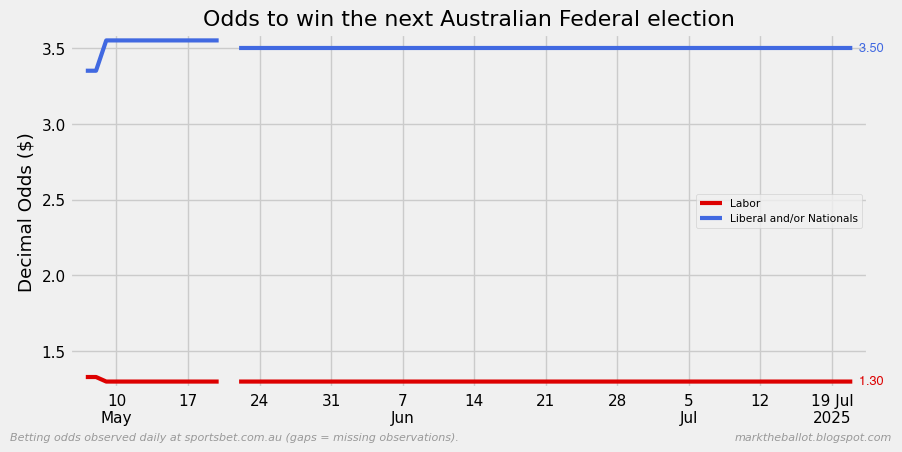

In [8]:
def plot_party_odds(
    df: pd.DataFrame,
    starts: tuple[int | pd.Period, ...] = (0,),
) -> None:
    """
    Plot the party odds to win the next Australian Federal election.
    """

    colors = mg.colorise_list(df.columns)
    mg.multi_start(
        df,
        function=mg.line_plot_finalise,
        starts=starts,
        color=colors,
        title="Odds to win the next Australian Federal election",
        xlabel=None,
        ylabel="Decimal Odds ($)",
        legend=True,
        width=3,
        annotate=True,
        rounding=2,
        dropna=False,
        **footers,
        show=SHOW,
    )


plot_party_odds(core_odds)

In [9]:
def convert(odds: pd.DataFrame) -> pd.DataFrame:
    """
    Convert decimal odds to adjusted probabilities
    (ie, scaled to sum to one; addressing the bookmaker's over-round).
    """

    # get raw probabilities
    raw_probs = 1 / odds

    # remove the bookmakers over-round
    total = raw_probs.sum(axis=1)
    probability = raw_probs.div(total, axis=0)

    return probability * 100  # convert to percentage


adj_probs = convert(core_odds)

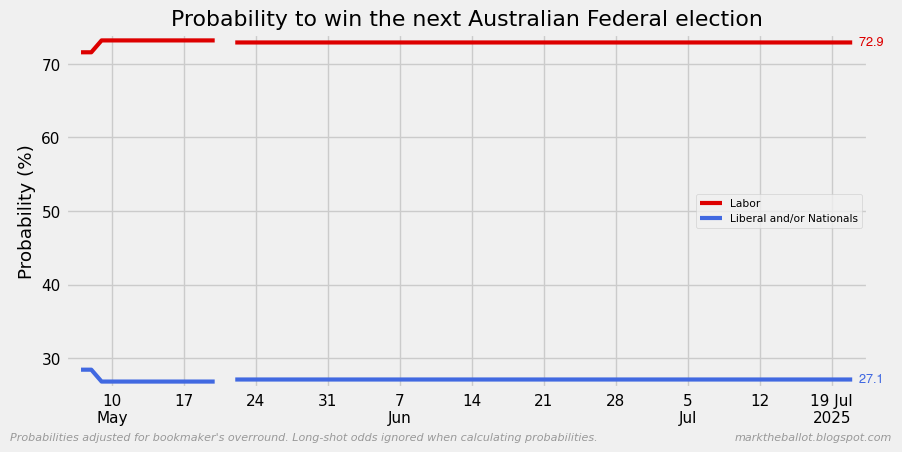

In [10]:
def plot_probabilities(
    df: pd.DataFrame,
    starts: tuple[int | pd.Period, ...] = (0,),
) -> None:
    """Plot the adjusted probabilities of winning the next election."""

    colors = mg.colorise_list(df.columns)
    lfooter = (
        "Probabilities adjusted for bookmaker's overround. "
        "Long-shot odds ignored when calculating probabilities. "
    )
    mg.multi_start(
        df,
        function=mg.line_plot_finalise,
        starts=starts,
        color=colors,
        title="Probability to win the next Australian Federal election",
        xlabel=None,
        ylabel="Probability (%)",
        legend=True,
        width=3,
        annotate=True,
        rounding=1,
        dropna=False,
        lfooter=lfooter,
        rfooter=RFOOTER,
        show=SHOW,
    )


plot_probabilities(adj_probs)

## Finished

In [11]:
%load_ext watermark
%watermark -t -d -u --python --machine --conda --iversions --watermark

Last updated: 2025-07-21 10:18:54

Python implementation: CPython
Python version       : 3.13.5
IPython version      : 9.3.0

conda environment: n/a

Compiler    : Clang 20.1.4 
OS          : Darwin
Release     : 24.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

mgplot: 0.2.7a4
pandas: 2.3.0

Watermark: 2.5.0



In [12]:
print("It is done")

It is done
